# Training with LSTM

In this approach, I chose to use a **Long Short Term Memory** (aka. LSTM) model as it is a good model to make predictions in numeric series. You can read below some additional descriptions of this approach.

In [31]:
import copy
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as sk_train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
def get_categories(df):
    return df['category'].unique()

In [4]:
# Load the Keras tokenizer
# Note that it will use only the most "num_words" used words
def load_tokenizer(X_data, num_words=150000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X_data)
    return tokenizer

In [6]:
def data_to_sequences(X_data, tokenizer, max_sequence_length):
    X_data = tokenizer.texts_to_sequences(X_data)
    X_data = sequence.pad_sequences(X_data, maxlen=max_sequence_length)
    return X_data

In [7]:
def train_test_split(X_data, Y_data, tokenizer, max_sequence_length):
    X_data = data_to_sequences(X_data, tokenizer, max_sequence_length)
    
    Y_data = Y_data.astype(np.int32)
    X_train, X_test, Y_train, Y_test = sk_train_test_split(X_data, Y_data, test_size=0.3)
    
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return X_train, X_test, Y_train, Y_test

## Prepare dataset

Since the LSTM layer process sequences of number, I needed to **transform the texts into numbers**, so I used Keras Tokenizer to transform them. The Tokenizer contains a dictionary word-number, so every text we tokenize will be the same.

In [9]:
df = pd.read_csv('../data/parsed/tfidf_dataset.csv')
df.head()

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment


In [10]:
X_data = df[['text']].to_numpy().reshape(-1)
Y_data = df[['category']].to_numpy().reshape(-1)

I must to something similar with the categories: I only can **predict classes in a numeric format**, I had to transform each category into a number.

In [12]:
category_to_id = {}
category_to_name = {}

for index, c in enumerate(Y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    Y_data[index] = category_id

# Display dictionary
category_to_name

{0: 'entertainment', 1: 'sport', 2: 'business', 3: 'politics', 4: 'tech'}

I have **padded the short texts** with zeros and, in case that there are texts longer than a certain length (I fixed this value to $1000$ words), cut them (so all texts are the same length).

In [13]:
MAX_SEQUENCE_LENGTH = 1000

n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

n_categories = len(get_categories(df))
print('Number of categories: %d' % n_categories)

print('Loading tokenizer...')
tokenizer = load_tokenizer(X_data)

print('Loading train dataset...')
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, tokenizer, MAX_SEQUENCE_LENGTH)

print('Done!')

Texts in dataset: 2225
Number of categories: 5
Max sequence lengths: 1000
Loading tokenizer...
Loading train dataset...
Done!


## Create model and train

I have used the loss function $SparseCategoricalCrossentropy$ since I have a multi-class problem. This model returns **a vector of probabilities** where each value is the probability for each *category* (hence I must pick the highest one).

In the first layer of the model, I have used a **pre-trained set of embedding vectors** (so I should get more accurate results). These embeddings have been trained over Wikipedia 2014 database using the top $400K$ words (source: http://nlp.stanford.edu/data/glove.6B.zip). However, some words might not be present in that embedding set, so I have initialized the vectors (of those "missing words") with zeros.

Since the classes are not highly unbalanced, I have used **accuracy** to measure each model and find the best one. In other cases, you should consider to use a different metric, e.g. F1-score.

In [5]:
def load_embedding_matrix(tokenizer):
    embedding_dim = 100
    embeddings_index = {}

    f = open('../data/glove.6B/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix, embedding_dim

In [90]:
def create_lstm_model(model_params, tokenizer, input_length, n_categories):
    word_index = tokenizer.word_index
    embedding_matrix, embedding_dim = load_embedding_matrix(tokenizer)

    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=input_length,
                        trainable=True))
    model.add(SpatialDropout1D(model_params['spartial_dropout']))
    model.add(LSTM(64,
                   activation=model_params['lstm_activation'],
                   dropout=model_params['lstm_dropout'],
                   recurrent_dropout=model_params['recurrent_dropout']))
    model.add(Dense(n_categories, activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

I have created a dictionary of parameters with different values to use during the training (aka. **hyperparameter optimization**). I trained the model with every permutation of these parameters and, then, I have chosen the one which give the best results.

In [111]:
# This is a recursive function to generate all permutations, so ignore the parameter combination
def tunning_params_combinations(tunning_params, combination={}):
    if len(tunning_params) == 0:
        return [combination]
    
    found_combinations = []
    
    # Get first param
    param_name = next(iter(tunning_params))
    param_values = tunning_params[param_name]
        
    for v in param_values:
        c = copy.deepcopy(combination)
        sub_tp = copy.deepcopy(tunning_params)

        del sub_tp[param_name]
        c[param_name] = v

        found_combinations = found_combinations + tunning_params_combinations(sub_tp, c)
    
    return found_combinations

In [91]:
EPOCHS = 10

tunning_params = {
    'lstm_activation': ['relu', 'tanh'],
    'spartial_dropout': [0.2, 0.3, 0.5, 0.7],
    'lstm_dropout': [0.2, 0.3, 0.5, 0.7],
    'recurrent_dropout': [0.2, 0.3, 0.5, 0.7]
}

best_accuracy = -1
model = None
best_params = {}

for p in tunning_params_combinations(tunning_params):
    print('- Training with parameters: ')
    print(p)

    current_model = create_lstm_model(p, tokenizer, MAX_SEQUENCE_LENGTH, n_categories)
    current_history = current_model.fit(X_train,
                                        Y_train,
                                        epochs=EPOCHS,
                                        validation_data=(X_test, Y_test),
                                        verbose=1)

    current_accuracy = current_history.history['val_accuracy'][-1]
    print('  Model accuracy: %.2f' % current_accuracy)

    if best_accuracy == -1 or best_accuracy < current_accuracy:
        best_accuracy = current_accuracy
        best_params = p
        model = current_model
        history = current_history

print('-' * 10)
print('Best Accuracy: %.2f' % best_accuracy)
print('Best params:')
print(best_params)

print('Finished!')

- Training with parameters: 
{'lstm_activation': 'relu', 'spartial_dropout': 0.2, 'lstm_dropout': 0.2, 'recurrent_dropout': 0.2}
Epoch 1/10
49/49 [==============================] - 84s 2s/step - loss: 2.1387 - accuracy: 0.5241 - val_loss: 1.2785 - val_accuracy: 0.6602
Epoch 2/10
49/49 [==============================] - 75s 2s/step - loss: 2.0044 - accuracy: 0.5793 - val_loss: 1.3851 - val_accuracy: 0.5778
Epoch 3/10
49/49 [==============================] - 75s 2s/step - loss: 1.3473 - accuracy: 0.5723 - val_loss: 1.3517 - val_accuracy: 0.6243
Epoch 4/10
49/49 [==============================] - 74s 2s/step - loss: 1.3058 - accuracy: 0.6243 - val_loss: 1.3182 - val_accuracy: 0.6497
Epoch 5/10
49/49 [==============================] - 75s 2s/step - loss: 1.2594 - accuracy: 0.6442 - val_loss: 1.2846 - val_accuracy: 0.6647
Epoch 6/10
49/49 [==============================] - 74s 2s/step - loss: 1.2093 - accuracy: 0.6680 - val_loss: 1.2508 - val_accuracy: 0.6811
Epoch 7/10
49/49 [=============

49/49 [==============================] - 73s 1s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 8/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 9/10
49/49 [==============================] - 73s 1s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 10/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
  Model accuracy: 0.16
- Training with parameters: 
{'lstm_activation': 'relu', 'spartial_dropout': 0.2, 'lstm_dropout': 0.5, 'recurrent_dropout': 0.7}
Epoch 1/10
49/49 [==============================] - 74s 2s/step - loss: 1.4478 - accuracy: 0.4470 - val_loss: 1.2856 - val_accuracy: 0.6632
Epoch 2/10
49/49 [==============================] - 74s 2s/step - loss: 1.2799 - accuracy: 0.5588 - val_loss: 1.2520 - val_accuracy: 0.6946
Epoch 3/10
49/49 [========================

Epoch 3/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 4/10
49/49 [==============================] - 73s 1s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 5/10
49/49 [==============================] - 76s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 6/10
49/49 [==============================] - 78s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 7/10
49/49 [==============================] - 75s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 8/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 9/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 10/10
49/49 [==============================] - 74s 2s/st

Epoch 8/10
49/49 [==============================] - 74s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 9/10
49/49 [==============================] - 73s 1s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 10/10
49/49 [==============================] - 73s 1s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
  Model accuracy: 0.16
- Training with parameters: 
{'lstm_activation': 'relu', 'spartial_dropout': 0.3, 'lstm_dropout': 0.5, 'recurrent_dropout': 0.7}
Epoch 1/10
49/49 [==============================] - 74s 2s/step - loss: 1.4176 - accuracy: 0.3905 - val_loss: 12169019392.0000 - val_accuracy: 0.7096
Epoch 2/10
49/49 [==============================] - 74s 2s/step - loss: 1.2050 - accuracy: 0.6024 - val_loss: 2927373.2500 - val_accuracy: 0.6811
Epoch 3/10
49/49 [==============================] - 74s 2s/step - loss: 1.4039 - accuracy: 0.5748 - val_loss: 24310.3418 - val_accuracy: 0.6781
Epoch

49/49 [==============================] - 74s 2s/step - loss: 1.0770 - accuracy: 0.6390 - val_loss: 1.0089 - val_accuracy: 0.7560
Epoch 6/10
49/49 [==============================] - 74s 2s/step - loss: 1.0115 - accuracy: 0.6423 - val_loss: 0.9386 - val_accuracy: 0.7590
Epoch 7/10
49/49 [==============================] - 74s 2s/step - loss: 0.9493 - accuracy: 0.6789 - val_loss: 0.8731 - val_accuracy: 0.7695
Epoch 8/10
49/49 [==============================] - 72s 1s/step - loss: 0.9123 - accuracy: 0.6821 - val_loss: 0.8191 - val_accuracy: 0.7799
Epoch 9/10
49/49 [==============================] - 73s 1s/step - loss: 0.8734 - accuracy: 0.6911 - val_loss: 0.7754 - val_accuracy: 0.7799
Epoch 10/10
49/49 [==============================] - 76s 2s/step - loss: 0.8231 - accuracy: 0.7180 - val_loss: 0.7344 - val_accuracy: 0.7829
  Model accuracy: 0.78
- Training with parameters: 
{'lstm_activation': 'relu', 'spartial_dropout': 0.5, 'lstm_dropout': 0.3, 'recurrent_dropout': 0.5}
Epoch 1/10
49/49 [

Epoch 2/10
49/49 [==============================] - 75s 2s/step - loss: nan - accuracy: 0.2055 - val_loss: nan - val_accuracy: 0.1632
Epoch 3/10
49/49 [==============================] - 85s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 4/10
49/49 [==============================] - 98s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 5/10
49/49 [==============================] - 78s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 6/10
49/49 [==============================] - 93s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 7/10
49/49 [==============================] - 96s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 8/10
49/49 [==============================] - 99s 2s/step - loss: nan - accuracy: 0.1779 - val_loss: nan - val_accuracy: 0.1632
Epoch 9/10
49/49 [==============================] - 85s 2s/ste

Epoch 6/10
49/49 [==============================] - 81s 2s/step - loss: 1.0814 - accuracy: 0.5915 - val_loss: 0.9486 - val_accuracy: 0.7754
Epoch 7/10
49/49 [==============================] - 84s 2s/step - loss: 1.0467 - accuracy: 0.6057 - val_loss: 0.8838 - val_accuracy: 0.7859
Epoch 8/10
49/49 [==============================] - 76s 2s/step - loss: 1.0058 - accuracy: 0.6275 - val_loss: 0.8636 - val_accuracy: 0.7859
Epoch 9/10
49/49 [==============================] - 76s 2s/step - loss: 0.9864 - accuracy: 0.6493 - val_loss: 0.8323 - val_accuracy: 0.7919
Epoch 10/10
49/49 [==============================] - 87s 2s/step - loss: 1.0224 - accuracy: 0.6294 - val_loss: 5.4364 - val_accuracy: 0.7725
  Model accuracy: 0.77
- Training with parameters: 
{'lstm_activation': 'relu', 'spartial_dropout': 0.7, 'lstm_dropout': 0.3, 'recurrent_dropout': 0.5}
Epoch 1/10
49/49 [==============================] - 89s 2s/step - loss: 1.5770 - accuracy: 0.3410 - val_loss: 1.3810 - val_accuracy: 0.6183
Epoch 2

Epoch 1/10
49/49 [==============================] - 116s 2s/step - loss: 1.1251 - accuracy: 0.6012 - val_loss: 0.4944 - val_accuracy: 0.8578
Epoch 2/10
49/49 [==============================] - 116s 2s/step - loss: 0.4155 - accuracy: 0.8793 - val_loss: 0.5130 - val_accuracy: 0.8728
Epoch 3/10
49/49 [==============================] - 126s 3s/step - loss: 0.5562 - accuracy: 0.8574 - val_loss: 0.2604 - val_accuracy: 0.9341
Epoch 4/10
49/49 [==============================] - 143s 3s/step - loss: 0.2395 - accuracy: 0.9338 - val_loss: 0.2230 - val_accuracy: 0.9506
Epoch 5/10
49/49 [==============================] - 141s 3s/step - loss: 0.1545 - accuracy: 0.9589 - val_loss: 0.2326 - val_accuracy: 0.9386
Epoch 6/10
49/49 [==============================] - 118s 2s/step - loss: 0.1568 - accuracy: 0.9576 - val_loss: 0.1938 - val_accuracy: 0.9491
Epoch 7/10
49/49 [==============================] - 130s 3s/step - loss: 0.1270 - accuracy: 0.9698 - val_loss: 0.2426 - val_accuracy: 0.9416
Epoch 8/10
49

Epoch 4/10
49/49 [==============================] - 74s 2s/step - loss: 0.2831 - accuracy: 0.9127 - val_loss: 0.2327 - val_accuracy: 0.9446
Epoch 5/10
49/49 [==============================] - 75s 2s/step - loss: 0.1825 - accuracy: 0.9499 - val_loss: 0.1949 - val_accuracy: 0.9461
Epoch 6/10
49/49 [==============================] - 78s 2s/step - loss: 0.1712 - accuracy: 0.9550 - val_loss: 0.1938 - val_accuracy: 0.9446
Epoch 7/10
49/49 [==============================] - 76s 2s/step - loss: 0.1602 - accuracy: 0.9563 - val_loss: 0.2096 - val_accuracy: 0.9431
Epoch 8/10
49/49 [==============================] - 75s 2s/step - loss: 0.1398 - accuracy: 0.9608 - val_loss: 0.1674 - val_accuracy: 0.9506
Epoch 9/10
49/49 [==============================] - 76s 2s/step - loss: 0.1615 - accuracy: 0.9544 - val_loss: 0.3146 - val_accuracy: 0.9072
Epoch 10/10
49/49 [==============================] - 77s 2s/step - loss: 0.1568 - accuracy: 0.9563 - val_loss: 0.3515 - val_accuracy: 0.8952
  Model accuracy: 0

49/49 [==============================] - 71s 1s/step - loss: 0.1767 - accuracy: 0.9505 - val_loss: 0.2758 - val_accuracy: 0.9207
Epoch 8/10
49/49 [==============================] - 71s 1s/step - loss: 0.1567 - accuracy: 0.9563 - val_loss: 0.1535 - val_accuracy: 0.9611
Epoch 9/10
49/49 [==============================] - 71s 1s/step - loss: 0.2212 - accuracy: 0.9383 - val_loss: 0.2512 - val_accuracy: 0.9356
Epoch 10/10
49/49 [==============================] - 71s 1s/step - loss: 0.1476 - accuracy: 0.9576 - val_loss: 0.3382 - val_accuracy: 0.9266
  Model accuracy: 0.93
- Training with parameters: 
{'lstm_activation': 'tanh', 'spartial_dropout': 0.2, 'lstm_dropout': 0.5, 'recurrent_dropout': 0.7}
Epoch 1/10
49/49 [==============================] - 71s 1s/step - loss: 1.3257 - accuracy: 0.5061 - val_loss: 0.6908 - val_accuracy: 0.7889
Epoch 2/10
49/49 [==============================] - 70s 1s/step - loss: 0.5363 - accuracy: 0.8382 - val_loss: 0.5863 - val_accuracy: 0.8114
Epoch 3/10
49/49 [

49/49 [==============================] - 73s 1s/step - loss: 0.5127 - accuracy: 0.8433 - val_loss: 0.5286 - val_accuracy: 0.8638
Epoch 3/10
49/49 [==============================] - 73s 1s/step - loss: 0.3124 - accuracy: 0.9088 - val_loss: 0.3774 - val_accuracy: 0.8952
Epoch 4/10
49/49 [==============================] - 73s 1s/step - loss: 0.2766 - accuracy: 0.9159 - val_loss: 0.3590 - val_accuracy: 0.8982
Epoch 5/10
49/49 [==============================] - 72s 1s/step - loss: 0.2434 - accuracy: 0.9223 - val_loss: 0.1969 - val_accuracy: 0.9356
Epoch 6/10
49/49 [==============================] - 73s 1s/step - loss: 0.1887 - accuracy: 0.9473 - val_loss: 0.1954 - val_accuracy: 0.9491
Epoch 7/10
49/49 [==============================] - 73s 1s/step - loss: 0.1666 - accuracy: 0.9563 - val_loss: 0.1739 - val_accuracy: 0.9536
Epoch 8/10
49/49 [==============================] - 73s 1s/step - loss: 0.1193 - accuracy: 0.9679 - val_loss: 0.2253 - val_accuracy: 0.9416
Epoch 9/10
49/49 [=============

49/49 [==============================] - 70s 1s/step - loss: 0.3062 - accuracy: 0.9127 - val_loss: 0.6643 - val_accuracy: 0.8668
Epoch 9/10
49/49 [==============================] - 70s 1s/step - loss: 0.2611 - accuracy: 0.9204 - val_loss: 0.7392 - val_accuracy: 0.8368
Epoch 10/10
49/49 [==============================] - 71s 1s/step - loss: 0.2467 - accuracy: 0.9268 - val_loss: 1.4907 - val_accuracy: 0.7231
  Model accuracy: 0.72
- Training with parameters: 
{'lstm_activation': 'tanh', 'spartial_dropout': 0.5, 'lstm_dropout': 0.2, 'recurrent_dropout': 0.2}
Epoch 1/10
49/49 [==============================] - 72s 1s/step - loss: 1.3996 - accuracy: 0.4425 - val_loss: 0.8161 - val_accuracy: 0.7665
Epoch 2/10
49/49 [==============================] - 72s 1s/step - loss: 0.7195 - accuracy: 0.7688 - val_loss: 0.3790 - val_accuracy: 0.8967
Epoch 3/10
49/49 [==============================] - 72s 1s/step - loss: 0.4298 - accuracy: 0.8645 - val_loss: 0.3134 - val_accuracy: 0.9177
Epoch 4/10
49/49 [

Epoch 1/10
49/49 [==============================] - 75s 2s/step - loss: 1.3821 - accuracy: 0.4464 - val_loss: 0.7576 - val_accuracy: 0.7725
Epoch 2/10
49/49 [==============================] - 71s 1s/step - loss: 0.7531 - accuracy: 0.7521 - val_loss: 0.5148 - val_accuracy: 0.8533
Epoch 3/10
49/49 [==============================] - 71s 1s/step - loss: 0.5809 - accuracy: 0.8080 - val_loss: 0.4133 - val_accuracy: 0.8877
Epoch 4/10
49/49 [==============================] - 72s 1s/step - loss: 0.3762 - accuracy: 0.8844 - val_loss: 0.2790 - val_accuracy: 0.9237
Epoch 5/10
49/49 [==============================] - 72s 1s/step - loss: 0.3540 - accuracy: 0.8863 - val_loss: 0.2901 - val_accuracy: 0.9237
Epoch 6/10
49/49 [==============================] - 71s 1s/step - loss: 0.4022 - accuracy: 0.8696 - val_loss: 0.2016 - val_accuracy: 0.9461
Epoch 7/10
49/49 [==============================] - 71s 1s/step - loss: 0.2630 - accuracy: 0.9184 - val_loss: 0.2056 - val_accuracy: 0.9461
Epoch 8/10
49/49 [==

49/49 [==============================] - 72s 1s/step - loss: 0.4542 - accuracy: 0.8529 - val_loss: 0.9327 - val_accuracy: 0.8159
Epoch 5/10
49/49 [==============================] - 71s 1s/step - loss: 0.3788 - accuracy: 0.8902 - val_loss: 1.1524 - val_accuracy: 0.7590
Epoch 6/10
49/49 [==============================] - 71s 1s/step - loss: 0.4020 - accuracy: 0.8780 - val_loss: 0.6772 - val_accuracy: 0.8443
Epoch 7/10
49/49 [==============================] - 71s 1s/step - loss: 0.4054 - accuracy: 0.8760 - val_loss: 0.2076 - val_accuracy: 0.9491
Epoch 8/10
49/49 [==============================] - 72s 1s/step - loss: 0.3044 - accuracy: 0.9120 - val_loss: 0.2852 - val_accuracy: 0.9296
Epoch 9/10
49/49 [==============================] - 71s 1s/step - loss: 0.2548 - accuracy: 0.9229 - val_loss: 0.5741 - val_accuracy: 0.8802
Epoch 10/10
49/49 [==============================] - 71s 1s/step - loss: 0.3000 - accuracy: 0.9082 - val_loss: 0.5204 - val_accuracy: 0.8847
  Model accuracy: 0.88
- Train

49/49 [==============================] - 71s 1s/step - loss: 0.4255 - accuracy: 0.8703 - val_loss: 0.8143 - val_accuracy: 0.8159
  Model accuracy: 0.82
- Training with parameters: 
{'lstm_activation': 'tanh', 'spartial_dropout': 0.7, 'lstm_dropout': 0.3, 'recurrent_dropout': 0.3}
Epoch 1/10
49/49 [==============================] - 71s 1s/step - loss: 1.5605 - accuracy: 0.3025 - val_loss: 1.2605 - val_accuracy: 0.6452
Epoch 2/10
49/49 [==============================] - 71s 1s/step - loss: 1.3148 - accuracy: 0.5067 - val_loss: 0.7538 - val_accuracy: 0.6811
Epoch 3/10
49/49 [==============================] - 70s 1s/step - loss: 0.9433 - accuracy: 0.6423 - val_loss: 0.8774 - val_accuracy: 0.7365
Epoch 4/10
49/49 [==============================] - 70s 1s/step - loss: 0.7394 - accuracy: 0.7425 - val_loss: 0.4454 - val_accuracy: 0.8458
Epoch 5/10
49/49 [==============================] - 70s 1s/step - loss: 0.5916 - accuracy: 0.7996 - val_loss: 0.3217 - val_accuracy: 0.8937
Epoch 6/10
49/49 [=

49/49 [==============================] - 71s 1s/step - loss: 1.3537 - accuracy: 0.4624 - val_loss: 0.8208 - val_accuracy: 0.6362
Epoch 3/10
49/49 [==============================] - 71s 1s/step - loss: 1.0596 - accuracy: 0.5909 - val_loss: 1.8580 - val_accuracy: 0.5704
Epoch 4/10
49/49 [==============================] - 71s 1s/step - loss: 0.8238 - accuracy: 0.7013 - val_loss: 0.7773 - val_accuracy: 0.8069
Epoch 5/10
49/49 [==============================] - 70s 1s/step - loss: 0.7068 - accuracy: 0.7463 - val_loss: 1.4813 - val_accuracy: 0.6916
Epoch 6/10
49/49 [==============================] - 70s 1s/step - loss: 0.6485 - accuracy: 0.7726 - val_loss: 1.0466 - val_accuracy: 0.7829
Epoch 7/10
49/49 [==============================] - 70s 1s/step - loss: 0.6333 - accuracy: 0.7983 - val_loss: 1.1302 - val_accuracy: 0.7575
Epoch 8/10
49/49 [==============================] - 70s 1s/step - loss: 0.5629 - accuracy: 0.8272 - val_loss: 1.1187 - val_accuracy: 0.7515
Epoch 9/10
49/49 [=============

## Evaluation

After doing a quick review of the log of the training, I noticed that when I used `relu` as activation function of the LSTM layer, the value of the loss function is `NaN` in many cases.

Here I evaluated the best model that I found.

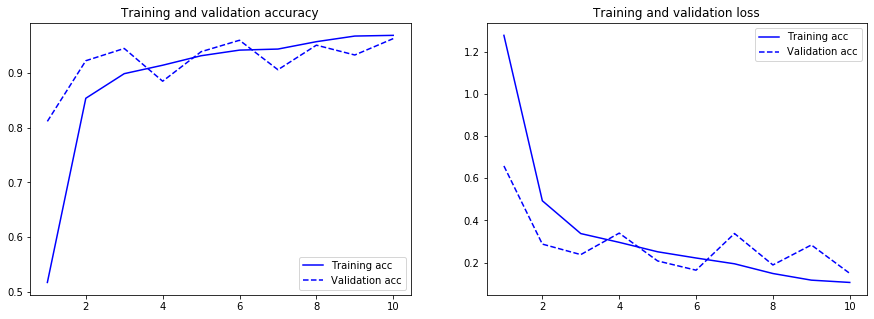

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_labels = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x_labels, acc, color='b', linestyle='-', label='Training acc')
plt.plot(x_labels, val_acc, color='b', linestyle='--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_labels, loss, color='b', linestyle='-', label='Training acc')
plt.plot(x_labels, val_loss, color='b', linestyle='--', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [95]:
def plot_confusion_matrix(X_test, Y_test, model):
    Y_pred = model.predict_classes(X_test)
    con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=Y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

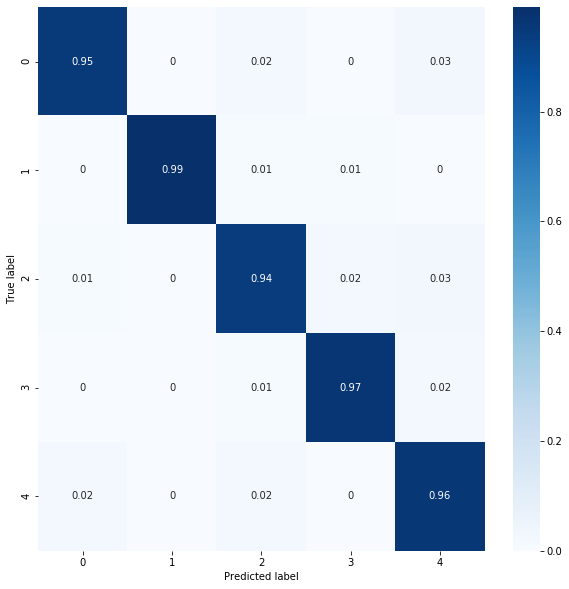

In [96]:
plot_confusion_matrix(X_test, Y_test, model)

In [93]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 96.26%


The global accuracy (i.e. taking into account all categories) looks pretty good for this selection of model and parameters: $96.26\%$.

If you take a closer look into the confussion matrix, you can see that most of mismatches are in the categories $0$ and $2$ which, according to the dictionary of category-ID, are `entertainment` and `business`.

In [100]:
category_to_name

{0: 'entertainment', 1: 'sport', 2: 'business', 3: 'politics', 4: 'tech'}

In [112]:
best_params

{'lstm_activation': 'tanh',
 'spartial_dropout': 0.3,
 'lstm_dropout': 0.2,
 'recurrent_dropout': 0.5}

## Save model and configuration

As I described above, I needed to store not only the model but also the tokenizer. If I had other variables (e.g. the value *MAX_SEQUENCE_LENGTH* could be computed using a different method rather than a constant in the code), I had needed to store them too.

In [101]:
def create_artifacts_dir():
    try:
        os.mkdir('../artifacts')
    except:
        pass

In [102]:
def save_tf_model(model):
    file_path = '../artifacts/lstm'
    model.save(file_path)

In [103]:
def save_tokenizer(tokenizer):
    with open('../artifacts/lstm/tokenizer.pickle', 'wb') as fp:
        pickle.dump(tokenizer, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
save_tf_model(model)
save_tokenizer(tokenizer)

INFO:tensorflow:Assets written to: ../artifacts/lstm/assets
